# Imports

In [1]:
import re
import nltk
import requests
import pandas as pd
import seaborn as sns
from nltk import ngrams
from nltk import FreqDist
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/congrendai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/congrendai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/congrendai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Activity 3

## 3.1 Sub-activity: Loading and pre-processing of text data

In [2]:
# Global variables
WIKIDATA_API_ENDPOINT = "https://www.wikidata.org/w/api.php"

WIKIDATA_COMMON_PARAMS = {
    "ids":"",
    "props": "",
    "format":"json",
    "languages": "en",
    "formatversion": "2",
    "sitefilter": "enwiki",
    "action": "wbgetentities"
}

### Task 1

In [3]:
def get_turing_award_recipients():
    """
    This function returns a list of all the Turing Award recipients
    During the requesting, we have to specify the some parameters for the API:
    
        srlimit: The maximum number of results to return. Default is 10.

        format: The format of the result

        list: Which lists to get. "search" performs a full text search

        action: The action to perform.

        formatversion: The format version to use. 
            2 is suggested by the API documentation

        srprop: Which properties to return. 
            "sectiontitle" returns the title of the matching section

        srsearch: The search string to use. 
            "haswbstatement:P166=Q185667" returns all the entities that have 
            the property P166 with the value Q185667
    
    Parameters
    ----------
    None

    Returns
    -------
    wikidata_IDs: list
        A list of Wikidata IDs of the Turing Award winners
    """

    wikidata_entity_params = {
        "srlimit":100,
        "format":"json",
        "list":"search",
        "action":"query",
        "formatversion": "2",
        "srprop":"sectiontitle",
        "srsearch": "haswbstatement:P166=Q185667",
    }
    
    wikidata_ID_response = requests.get(WIKIDATA_API_ENDPOINT, params = wikidata_entity_params)
    wikidata_ID_data = wikidata_ID_response.json()
    # Get the winner entity IDs from the response
    try:
        wikidata_IDs = [entity_ID["title"] for entity_ID in wikidata_ID_data["query"]["search"]]
    except KeyError:
        wikidata_IDs = []

    return wikidata_IDs

In [4]:
wikidata_IDs = get_turing_award_recipients()

### Task 2

In [5]:
def get_wikipedia_content(wikidata_ID):
    """
    This function returns the content of the wikipedia page 
    of the given wikidata ID

    

    Parameters:
    -----------
    wikidata_ID: string
        The wikidata ID of the entity

    Returns:
    --------
    wikipedia_content: string (HTML format)
        The content of the wikipedia page
    """
    wikipedia_API_endpoint = "https://en.wikipedia.org/w/api.php"
    
    WIKIDATA_COMMON_PARAMS["ids"] = wikidata_ID
    WIKIDATA_COMMON_PARAMS["props"] = "sitelinks"
    
    wikidata_response = requests.get(WIKIDATA_API_ENDPOINT, params = WIKIDATA_COMMON_PARAMS)
    wikidata_response_data = wikidata_response.json()

    """
    To extract content from the wikipidia page, we have to 
    use titles gained the wikidata IDs. These titles are
    wikipedia pages' titles and they are unique.
    """
    try:
        # Get the title of the wikipedia page from the wikidata API response
        wikidata_title = wikidata_response_data["entities"][wikidata_ID]["sitelinks"]["enwiki"]["title"]

        wikipedia_params = {
            "format": "json",
            "action": "query",
            "prop": "extracts",
            "formatversion": "2",
            "titles": wikidata_title,
            "exsectionformat": "wiki"
        }
    
        wikipedia_content_response = requests.get(wikipedia_API_endpoint, params = wikipedia_params)
        wikipedia_content_data = wikipedia_content_response.json()
        # Get the content of the wikipedia page from the wikipedia API response
        wikipedia_content = wikipedia_content_data["query"]["pages"][0]["extract"]
        
        return wikipedia_content
    
    # If the response does not have data, return an empty string
    except KeyError:
        wikipedia_content = ""
        return wikipedia_content

### Task 3

In [6]:
def get_award_winners_info(wikidata_ID):

    """
    This function returns information about the winners.

    We can directly get the name and birth date from
    the wikidata API response. However, other winners' properties
    such as gender, birth place, we have to get the entity IDs 
    first from the wikidata API response, and then use these IDs 
    to get the property values from the wikidata API response.

    To get the wikipedia page content, we have to use the titles 
    gained from the wikidata IDs (mentioned before in Task 2).

    Parameters:
    -----------
    wikidata_ID: string
        The wikidata ID of the entity
    
    Returns:
    --------
    entity_info: list
        A list of information about the winner includes name, birth date,
        gender, birth place, employer (list), and educated_at (list) of 
        each winner
    """
    
    WIKIDATA_COMMON_PARAMS["ids"] = wikidata_ID
    WIKIDATA_COMMON_PARAMS["props"] = "claims|sitelinks"

    response = requests.get(WIKIDATA_API_ENDPOINT, params = WIKIDATA_COMMON_PARAMS)
    data = response.json()

    # Extract name
    try:
        # Some names have brackets, so we split that part and take the name
        wikidata_name = data["entities"][wikidata_ID]["sitelinks"]["enwiki"]["title"].split(" (")[0]
    except KeyError:
        wikidata_name = None

    # Extract intro from wikipedia page
    try:
        wikipedia_content = get_wikipedia_content(wikidata_ID)
        # Remove newlines
        content_remove_newline_to_space = wikipedia_content.replace("\n", " ")
        # Remove tags except <p>
        content_with_p_tag = re.sub(r"<\/?(?!p)\w*\b[^>]*>", "", content_remove_newline_to_space.split("<h2>")[0])
        # Extract paragraphs within <p> tag
        paragraphs = re.findall(r'<p>(.+?)</p>', content_with_p_tag)
        # Join paragraphs with newlines
        wikipedia_intro = "\n".join(paragraphs)
    except KeyError:
        wikipedia_intro = None

    # Extract gender ID from "sex or gender (P21)"
    try:
        wikidata_gender_id = data["entities"][wikidata_ID]["claims"]["P21"][0]["mainsnak"]["datavalue"]["value"]["id"]
    except KeyError:
        wikidata_gender_id = None
        
    # Get birth date from "date of birth (P569)"
    try:
        wikidata_birth_date = data["entities"][wikidata_ID]["claims"]["P569"][0]["mainsnak"]["datavalue"]["value"]["time"].split("T")[0].split("+")[1]
    except KeyError:
        wikidata_birth_date = None

    # Extract birth place ID from "place of birth (P19)"
    try:
        wikidata_birth_place_id = data["entities"][wikidata_ID]["claims"]["P19"][0]["mainsnak"]["datavalue"]["value"]["id"]
    except KeyError:
        wikidata_birth_place_id = None

    """
    Since the wikidata API allows us to get more than one property at a time,
    and there are several values for employer and educated at, for optimization purposes,
    we can join the employer and educated_at IDs to get one response that has all values at once.
    """
    # Extract employer ID from "employer (P108)"
    try:
        # employer ID is inside of "mainsnak" key
        wikidata_employer_mainsnaks = data["entities"][wikidata_ID]["claims"]["P108"]
        wikidata_employer_IDs = "|".join([wikidata_employer_ID["mainsnak"]["datavalue"]["value"]["id"] for wikidata_employer_ID in wikidata_employer_mainsnaks])
    except KeyError:
        wikidata_employer_IDs = None
        
    # Extract educated at ID from "educated at (P69)"
    try:
        # educated at ID is inside of "mainsnak" key
        wikidata_educated_at_mainsnaks = data["entities"][wikidata_ID]["claims"]["P69"]
        wikidata_educated_at_IDs = "|".join([wikidata_educated_at_ID["mainsnak"]["datavalue"]["value"]["id"] for wikidata_educated_at_ID in wikidata_educated_at_mainsnaks])
    except KeyError:
        wikidata_educated_at_IDs = None

    # Join the entity IDs per winner, and then request them to get the property values
    entity_info_request_IDs = [wikidata_gender_id, wikidata_birth_place_id, wikidata_employer_IDs, wikidata_educated_at_IDs]
    
    # A list that contains all the info of the winner and will be returned eventually
    entity_info = [wikidata_name, wikipedia_intro, wikidata_birth_date]

    WIKIDATA_COMMON_PARAMS["props"] = "labels"
    for i in range(len(entity_info_request_IDs)):
        entity_values = []
        
        WIKIDATA_COMMON_PARAMS["ids"] = entity_info_request_IDs[i]
        
        response = requests.get(WIKIDATA_API_ENDPOINT, params = WIKIDATA_COMMON_PARAMS)
        data = response.json()

        # There is only one value for gender and birth place, 
        # so we don't need to split the ID to get the values
        if i == 0 or i == 1:
            try:
                entity_value = data["entities"][entity_info_request_IDs[i]]["labels"]["en"]["value"]
                entity_info.append(entity_value)
            except KeyError:
                entity_info.append(None)

        # To get the values of employer and educated at, 
        # we need to split the IDs that was sent first to get 
        # the values individually from the response
        else:
            try:
                entity_IDs = entity_info_request_IDs[i].split("|")
            except AttributeError:
                entity_IDs = []

            for entity_ID in entity_IDs:
                try:
                    entity_value = data["entities"][entity_ID]["labels"]["en"]["value"]
                    entity_values.append(entity_value)
                except KeyError:
                    entity_values.append(None)
            
            entity_info.append(entity_values)

    # Return name, intro, birth date, gender, birth place, employer, and educated_at of each winner
    return entity_info[0], entity_info[1], entity_info[2], entity_info[3], entity_info[4], entity_info[5], entity_info[6]

In [7]:
# Create a dictionary that stores the information of each winner
award_winners = {
    "name": [],
    "intro": [],
    "birth_date": [],
    "gender": [],
    "birth_place": [],
    "employer": [],
    "educated_at": []
}

# Loop through each winner and get information of them
for wikidata_ID in wikidata_IDs:
    wikidata_name, wikipedia_intro, wikidata_birth_date, wikidata_gender, wikidata_birth_place, wikidata_employer, wikidata_educated_at = get_award_winners_info(wikidata_ID)
    award_winners["name"].append(wikidata_name)
    award_winners["intro"].append(wikipedia_intro)
    award_winners["birth_date"].append(wikidata_birth_date)
    award_winners["gender"].append(wikidata_gender)
    award_winners["birth_place"].append(wikidata_birth_place)
    # Remove duplicates from employer and educated at
    award_winners["employer"].append(list(set(wikidata_employer)))
    award_winners["educated_at"].append(list(set(wikidata_educated_at)))

### Task 4

In [8]:
print("The names of all award winners in alphabetical order are : \n\n{}.".format(", ".join(sorted(award_winners["name"]))))

The names of all award winners in alphabetical order are : 

Adi Shamir, Alan Kay, Alan Perlis, Alfred Aho, Allen Newell, Amir Pnueli, Andrew Yao, Barbara Liskov, Bob Kahn, Butler Lampson, Charles Bachman, Charles P. Thacker, Dana Scott, David Patterson, Dennis Ritchie, Donald Knuth, Douglas Engelbart, E. Allen Emerson, Edgar F. Codd, Edmund M. Clarke, Edsger W. Dijkstra, Edward Feigenbaum, Edwin Catmull, Fernando J. Corbató, Frances Allen, Fred Brooks, Geoffrey Hinton, Herbert A. Simon, Ivan Sutherland, Jack Dongarra, James H. Wilkinson, Jeffrey Ullman, Jim Gray, John Backus, John Cocke, John Hopcroft, John L. Hennessy, John McCarthy, Joseph Sifakis, Judea Pearl, Juris Hartmanis, Ken Thompson, Kenneth E. Iverson, Kristen Nygaard, Leonard Adleman, Leslie Lamport, Leslie Valiant, Manuel Blum, Martin Hellman, Marvin Minsky, Maurice Wilkes, Michael O. Rabin, Michael Stonebraker, Niklaus Wirth, Ole-Johan Dahl, Pat Hanrahan, Peter Naur, Raj Reddy, Richard E. Stearns, Richard Hamming, Richar

### Task 5

#### (a)

In [9]:
# Create a dataframe that has name, count of words, sentences, paragraphs, and common words of each winner
award_winners_intro = pd.DataFrame(columns = ["winner_name", "count_words", "count_sentences", "count_paragraphs", "common_words"])

#### (b)

In [10]:
# Add name of each winner
award_winners_intro["winner_name"] = award_winners["name"]

# Count words
# Regex "[^\w\s]" searches all alphanumeric characters and numbers
award_winners_intro["count_words"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: re.sub(r"[^\w\s]", "", x[0]).split(), axis = 1).apply(lambda x: len(x))

# Count sentences using NLTK's sent_tokenize()
award_winners_intro["count_sentences"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: sent_tokenize(x[0]), axis = 1).apply(lambda x: len(x))

# Count paragraphs by splitting the intro by newline
award_winners_intro["count_paragraphs"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: x[0].split("\n"), axis = 1).apply(lambda x: len(x))

# Get the 10 most frequently occurring words by using NLTK's FreqDist()
# after whuch join the words with a comma
award_winners_intro["common_words"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: FreqDist(x[0].split()).most_common(10), axis = 1).apply(lambda x: [i[0] for i in x])

#### (c)

In [11]:
# Get the English stopwords from NLTK
en_stopwords = stopwords.words("english")

# Remove stopwords and punctuations
# Since stopwords are lowercase, we need to check intro in lowercase.
award_winners_intro_remove_stopwords_and_punctuation = pd.DataFrame(award_winners["intro"]).apply(lambda x: " ".join([word for word in word_tokenize(re.sub(r"[^\w\s]", "", x[0])) if word.lower() not in en_stopwords]), axis = 1)

# Get the 10 most frequently occurring words 
# after removing stopwords and punctuations, 
# and then store them in a new column called
# common_words_after_preprocessing
award_winners_intro["common_words_after_preprocessing"] = award_winners_intro_remove_stopwords_and_punctuation.apply(lambda x: FreqDist(re.sub(r"[^\w\s]", "", x).split()).most_common(10)).apply(lambda x: [i[0] for i in x])

#### (d)

In [12]:
award_winners_intro.head(10)

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing
0,Tim Berners-Lee,359,17,4,"[the, of, and, He, a, is, Web, as, World, Wide]","[Web, World, Wide, BernersLee, Computer, Scien..."
1,Yoshua Bengio,91,4,2,"[and, the, of, for, Bengio, is, a, work, deep,...","[Bengio, work, deep, learning, Learning, Hinto..."
2,Geoffrey Hinton,181,8,3,"[the, and, of, for, in, Hinton, a, his, to, is]","[Hinton, computer, work, neural, networks, Goo..."
3,Donald Knuth,183,8,3,"[the, of, and, Knuth, computer, is, to, He, an...","[Knuth, computer, science, analysis, algorithm..."
4,Richard M. Karp,92,3,2,"[in, and, the, of, for, Karp, is, computer, th...","[Karp, computer, theory, algorithms, Richard, ..."
5,Robert Tarjan,62,3,1,"[and, is, the, of, Tarjan, at, Robert, Endre, ...","[Tarjan, University, Robert, Endre, born, Apri..."
6,Vint Cerf,64,2,1,"[the, of, and, is, National, Medal, Vinton, Gr...","[Internet, National, Medal, Vinton, Gray, Cerf..."
7,Judea Pearl,156,5,2,"[the, and, of, for, is, on, Pearl, a, in, Judea]","[Pearl, Judea, computer, probabilistic, artifi..."
8,Herbert A. Simon,180,7,2,"[the, of, and, was, in, science,, to, politica...","[science, political, computer, Simon, 2001, fi..."
9,Marvin Minsky,53,2,2,"[and, of, Minsky, the, AI, Marvin, Lee, (Augus...","[AI, Minsky, Marvin, Lee, August, 9, 1927, Jan..."


## 3.2 Sub-activity: Applying NLP operations on the corpus

### 3.2.1 Stemming

### Task 3

#### (a)

In [13]:
intro_words = []
for intro in award_winners["intro"]:
    # Remove punctuations
    tokens = word_tokenize(re.sub(r"[^\w\s]", "", intro))
    # Remove stopwords
    for word in tokens:
        if word.lower() not in en_stopwords:
            intro_words.append(word)

#### (b)

In [14]:
# To count the number of unique words, we need to lowercase all 
# words first since the FreqDist() function is case-sensitive
unique_words = len(FreqDist([word.lower() for word in intro_words]).keys())
print("The number of unique words in intro_words is: {}.".format(unique_words))

The number of unique words in intro_words is: 1645.


#### (c)

In [15]:
# Create an instance of PorterStemmer
porter_stemmer = PorterStemmer()
print("The number of unique words after porter stemming in intro_words is: {}.".format(len(FreqDist([porter_stemmer.stem(word) for word in intro_words]).keys())))

The number of unique words after porter stemming in intro_words is: 1427.


### Task 4

In [16]:
# Create an instance of SnowballStemmer
snowball_stemmer = SnowballStemmer("english")
print("The number of unique words in intro_words is: {}.".format(unique_words))
print("The number of unique words after snowball stemming in intro_words is: {}.".format(len(FreqDist([snowball_stemmer.stem(word) for word in intro_words]).keys())))

The number of unique words in intro_words is: 1645.
The number of unique words after snowball stemming in intro_words is: 1425.


### 3.2.2 Lemmatization

### Task 5

In [17]:
# Create an instance of WordNetLemmatizer
# WordNetLemmatizer() is case-sensitive, we need to lowercase each word
wordnet_lemmatizer = WordNetLemmatizer()
print("The number of unique words in intro_words is: {}.".format(unique_words))
print("The number of unique words after lemmatization in intro_words is: {}.".format(len(FreqDist([wordnet_lemmatizer.lemmatize(word.lower()) for word in intro_words]).keys())))

The number of unique words in intro_words is: 1645.
The number of unique words after lemmatization in intro_words is: 1572.


### 3.2.3 Finding synonyms and antonyms

### Task 6

#### (a)

In [18]:
# Add synonyms and antonyms columns to award_winners_intro dataframe
award_winners_intro = award_winners_intro.reindex(award_winners_intro.columns.to_list() + ["synonyms", "antonyms"], axis = 1)

#### (b)

In [19]:
# The code was retrieved from https://www.geeksforgeeks.org/get-synonymsantonyms-nltk-wordnet-python/
def get_synonyms(words):
    """
    This function gets a list of synonyms of the intro words.

    Parameters
    ----------
    words : list
        A list of intro words.

    Returns
    -------
    synonyms : list
        A list of synonyms of the intro words.
    """
    
    # Use a dictionary to store the synonyms of each word
    # to maintain the uniqueness and order of the synonyms
    synonyms = {}
    for word in words:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms[word] = lemma.name()
    return list(synonyms.values())

In [20]:
# Add synonyms to the synonyms column
award_winners_intro["synonyms"] = award_winners_intro["common_words_after_preprocessing"].apply(lambda x: get_synonyms(x))

#### (c)

In [21]:
# The code was retrieved from https://www.geeksforgeeks.org/get-synonymsantonyms-nltk-wordnet-python/
def get_antonyms(words):
    """
    This function gets a list of antonyms of the intro words.

    Parameters
    ----------
    words : list
        A list of intro words.

    Returns
    -------
    antonyms : list
        A list of antonyms of the intro words.
    """

    # Use a dictionary to store the antonyms of each word
    # to maintain the uniqueness and order of the antonyms
    antonyms = {}
    for word in words:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                    antonyms[word] = lemma.antonyms()[0].name()
    return list(antonyms.values())

In [22]:
# Add antonyms to the antonyms column
award_winners_intro["antonyms"] = award_winners_intro["common_words_after_preprocessing"].apply(lambda x: get_antonyms(x))

#### (d)

In [23]:
award_winners_intro.head(10)


,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Tim Berners-Lee,359,17,4,"[the, of, and, He, a, is, Web, as, World, Wide]","[Web, World, Wide, BernersLee, Computer, Scien...","[net, world-wide, widely, computer, science, M...","[narrow, second, unknown]"
1,Yoshua Bengio,91,4,2,"[and, the, of, for, Bengio, is, a, work, deep,...","[Bengio, work, deep, learning, Learning, Hinto...","[work, deep, learn, learn, godfather, innate]","[malfunction, shallow, unborn]"
2,Geoffrey Hinton,181,8,3,"[the, and, of, for, in, Hinton, a, his, to, is]","[Hinton, computer, work, neural, networks, Goo...","[computer, work, neuronic, network, google, To...","[malfunction, shallow]"
3,Donald Knuth,183,8,3,"[the, of, and, Knuth, computer, is, to, He, an...","[Knuth, computer, science, analysis, algorithm...","[computer, science, depth_psychology, algorith...","[synthesis, undesigned]"
4,Richard M. Karp,92,3,2,"[in, and, the, of, for, Karp, is, computer, th...","[Karp, computer, theory, algorithms, Richard, ...","[computer, theory, algorithmic_program, man, i...",[unborn]
5,Robert Tarjan,62,3,1,"[and, is, the, of, Tarjan, at, Robert, Endre, ...","[Tarjan, University, Robert, Endre, born, Apri...","[university, Henry_Martyn_Robert, innate, Apr,...",[unborn]
6,Vint Cerf,64,2,1,"[the, of, and, is, National, Medal, Vinton, Gr...","[Internet, National, Medal, Vinton, Gray, Cerf...","[cyberspace, national, ribbon, gray, innate, J...","[local, unborn]"
7,Judea Pearl,156,5,2,"[the, and, of, for, is, on, Pearl, a, in, Judea]","[Pearl, Judea, computer, probabilistic, artifi...","[pearl, Judaea, computer, probabilistic, artif...","[natural, stupidity, nondevelopment]"
8,Herbert A. Simon,180,7,2,"[the, of, and, was, in, science,, to, politica...","[science, political, computer, Simon, 2001, fi...","[science, political, computer, Herbert_Alexand...",[nonpolitical]
9,Marvin Minsky,53,2,2,"[and, of, Minsky, the, AI, Marvin, Lee, (Augus...","[AI, Minsky, Marvin, Lee, August, 9, 1927, Jan...","[AI, lee, venerable, ix, Jan, xxiv]",[windward]


### 3.2.4 Bigrams and trigrams

### Task 7

In [24]:
# Tokenize the intro
intros_tokenized = []
for intro in award_winners["intro"]:
    tokens = word_tokenize(intro)
    intros_tokenized.append(tokens)

### Task 8

In [25]:
def get_bigrams_frequency(intros):
    """
    This function gets the bigrams and their frequencies from the intros of all winners.

    Parameters
    ----------
    intros : list
        A list of intro words that are tokenized of all winners.

    Returns
    -------
    bigrams : dictionary
        A dictionary of bigrams (keys) and their frequencies (values).
    """
    intro_no_punctuations_stopwords = []
    for intro in intros:
        for word in intro:
            # Remove punctuations and stopwords
            if word.lower() not in en_stopwords and word.isalnum():
                intro_no_punctuations_stopwords.append(word)

    # Get the bigrams and their frequencies
    bigrams = ngrams(intro_no_punctuations_stopwords, 2)
    
    return dict(FreqDist(bigrams))

### Task 9

In [26]:
winners_bigrams = get_bigrams_frequency(intros_tokenized)

### Task 10

In [27]:
# Sort the winner bigrams dictionary by their frequencies in descending order
most_15_common_bigrams = dict(sorted(winners_bigrams.items(), key = lambda x: x[1], reverse = True)[:15])
print("The most 15 most frequently occurring bigrams are: {}".format(", ".join(str(key) for key in list(most_15_common_bigrams.keys()))))

The most 15 most frequently occurring bigrams are: ('computer', 'scientist'), ('Turing', 'Award'), ('American', 'computer'), ('computer', 'science'), ('Computer', 'Science'), ('programming', 'language'), ('best', 'known'), ('National', 'Academy'), ('artificial', 'intelligence'), ('programming', 'languages'), ('received', 'Turing'), ('ACM', 'Turing'), ('Academy', 'Engineering'), ('Carnegie', 'Mellon'), ('Stanford', 'University')


## 3.3 Sub-section: Visualisation

### 3.3.1 Barplots

### Task 11

In [28]:
def plot_bar_chart(winner_name, count, figure_size, title):
    """
    This function plots a bar chart.

    Parameters
    ----------
    winner_name : list
        A list of winner names.

    count : list
        A list of counts (word, sentence, and paragraph).

    figure_size : tuple
        A tuple of the size of the plot.

    title : string

    Returns
    -------
    None.
    """
    # Set the size of the plot
    plt.figure(figsize = figure_size)
    # Add the title of the plot
    plt.title(title, fontsize = figure_size[0] * 0.75)
    # Plot the bar chart
    plt.bar(winner_name, count)
    # Rotate the name labels 45 degrees to have a better view
    plt.xticks(rotation = 45, ha = "right", rotation_mode='anchor')
    # Show the plot
    plt.show()

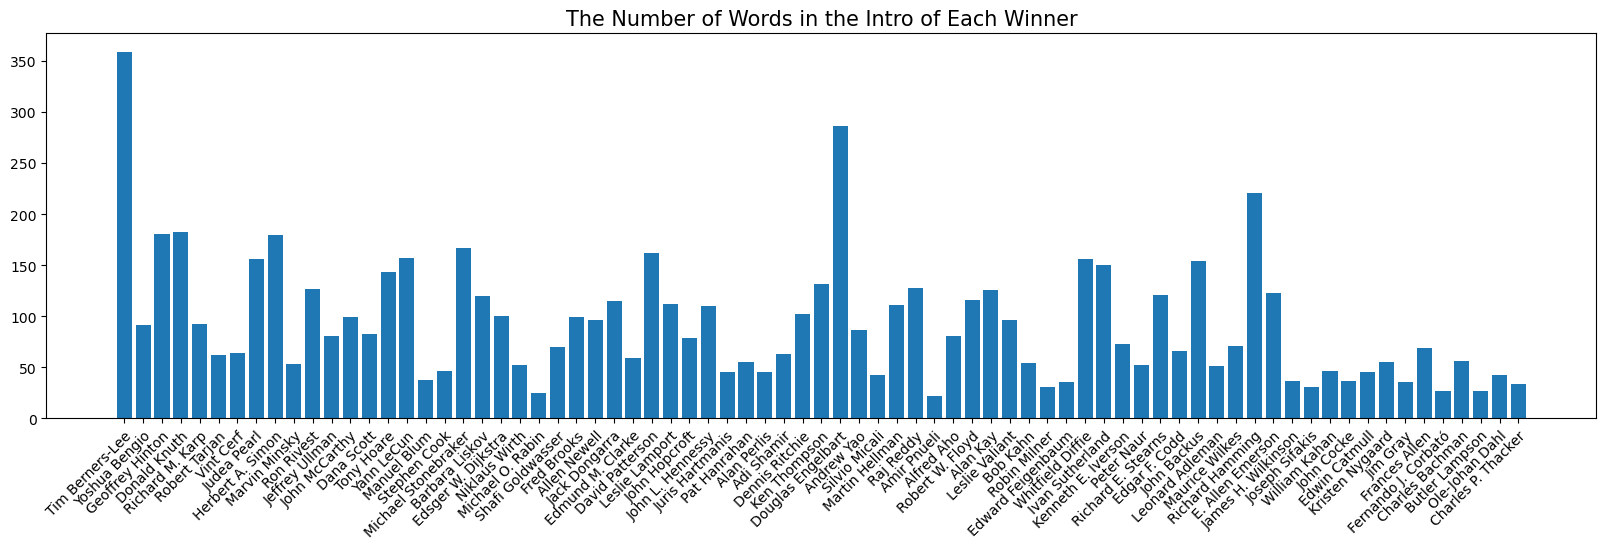

In [29]:
plot_bar_chart(award_winners_intro["winner_name"], award_winners_intro["count_words"], (20, 5), "The Number of Words in the Intro of Each Winner")

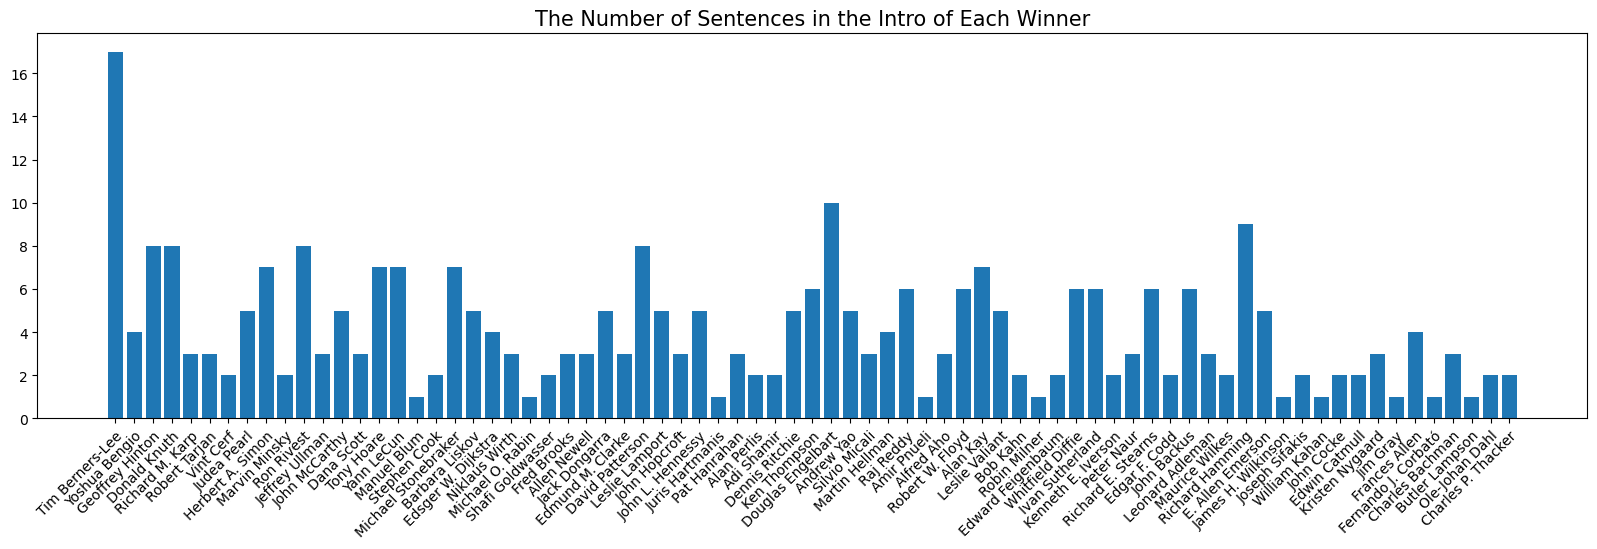

In [30]:
plot_bar_chart(award_winners_intro["winner_name"], award_winners_intro["count_sentences"], (20, 5), "The Number of Sentences in the Intro of Each Winner")

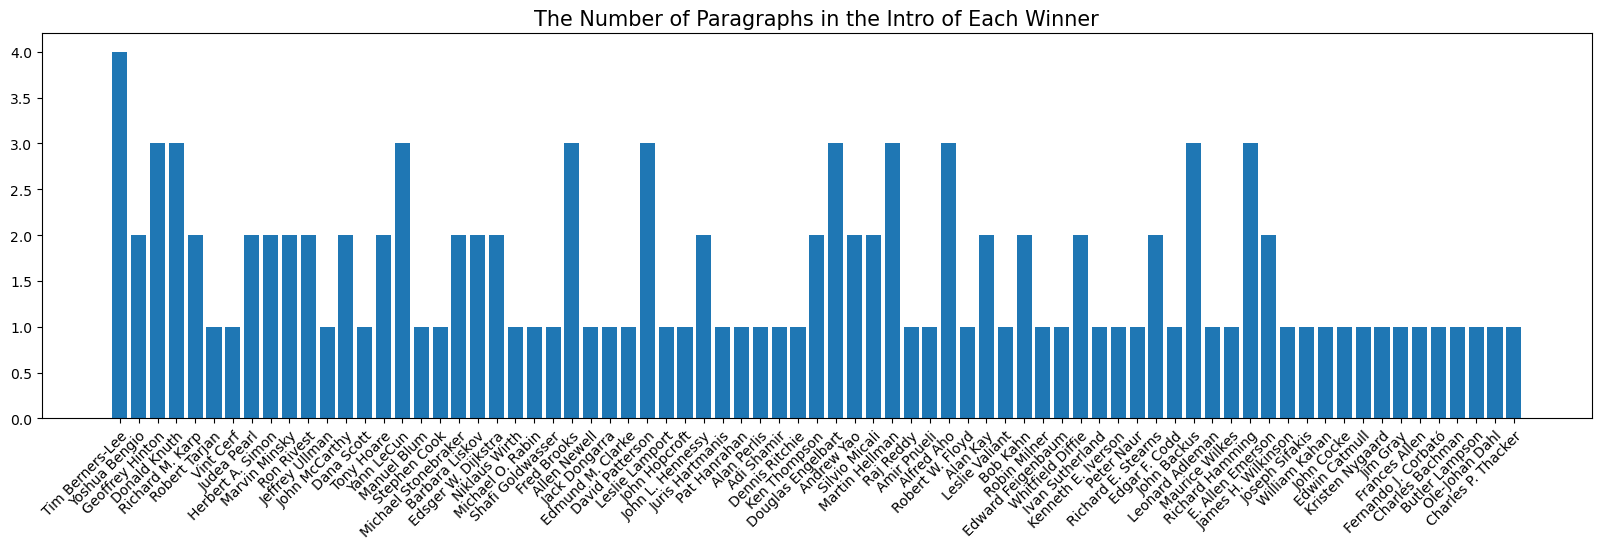

In [31]:
plot_bar_chart(award_winners_intro["winner_name"], award_winners_intro["count_paragraphs"], (20, 5), "The Number of Paragraphs in the Intro of Each Winner")

### Task 12

/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_21407/36686502.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_21407/36686502.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_21407/36686502.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')


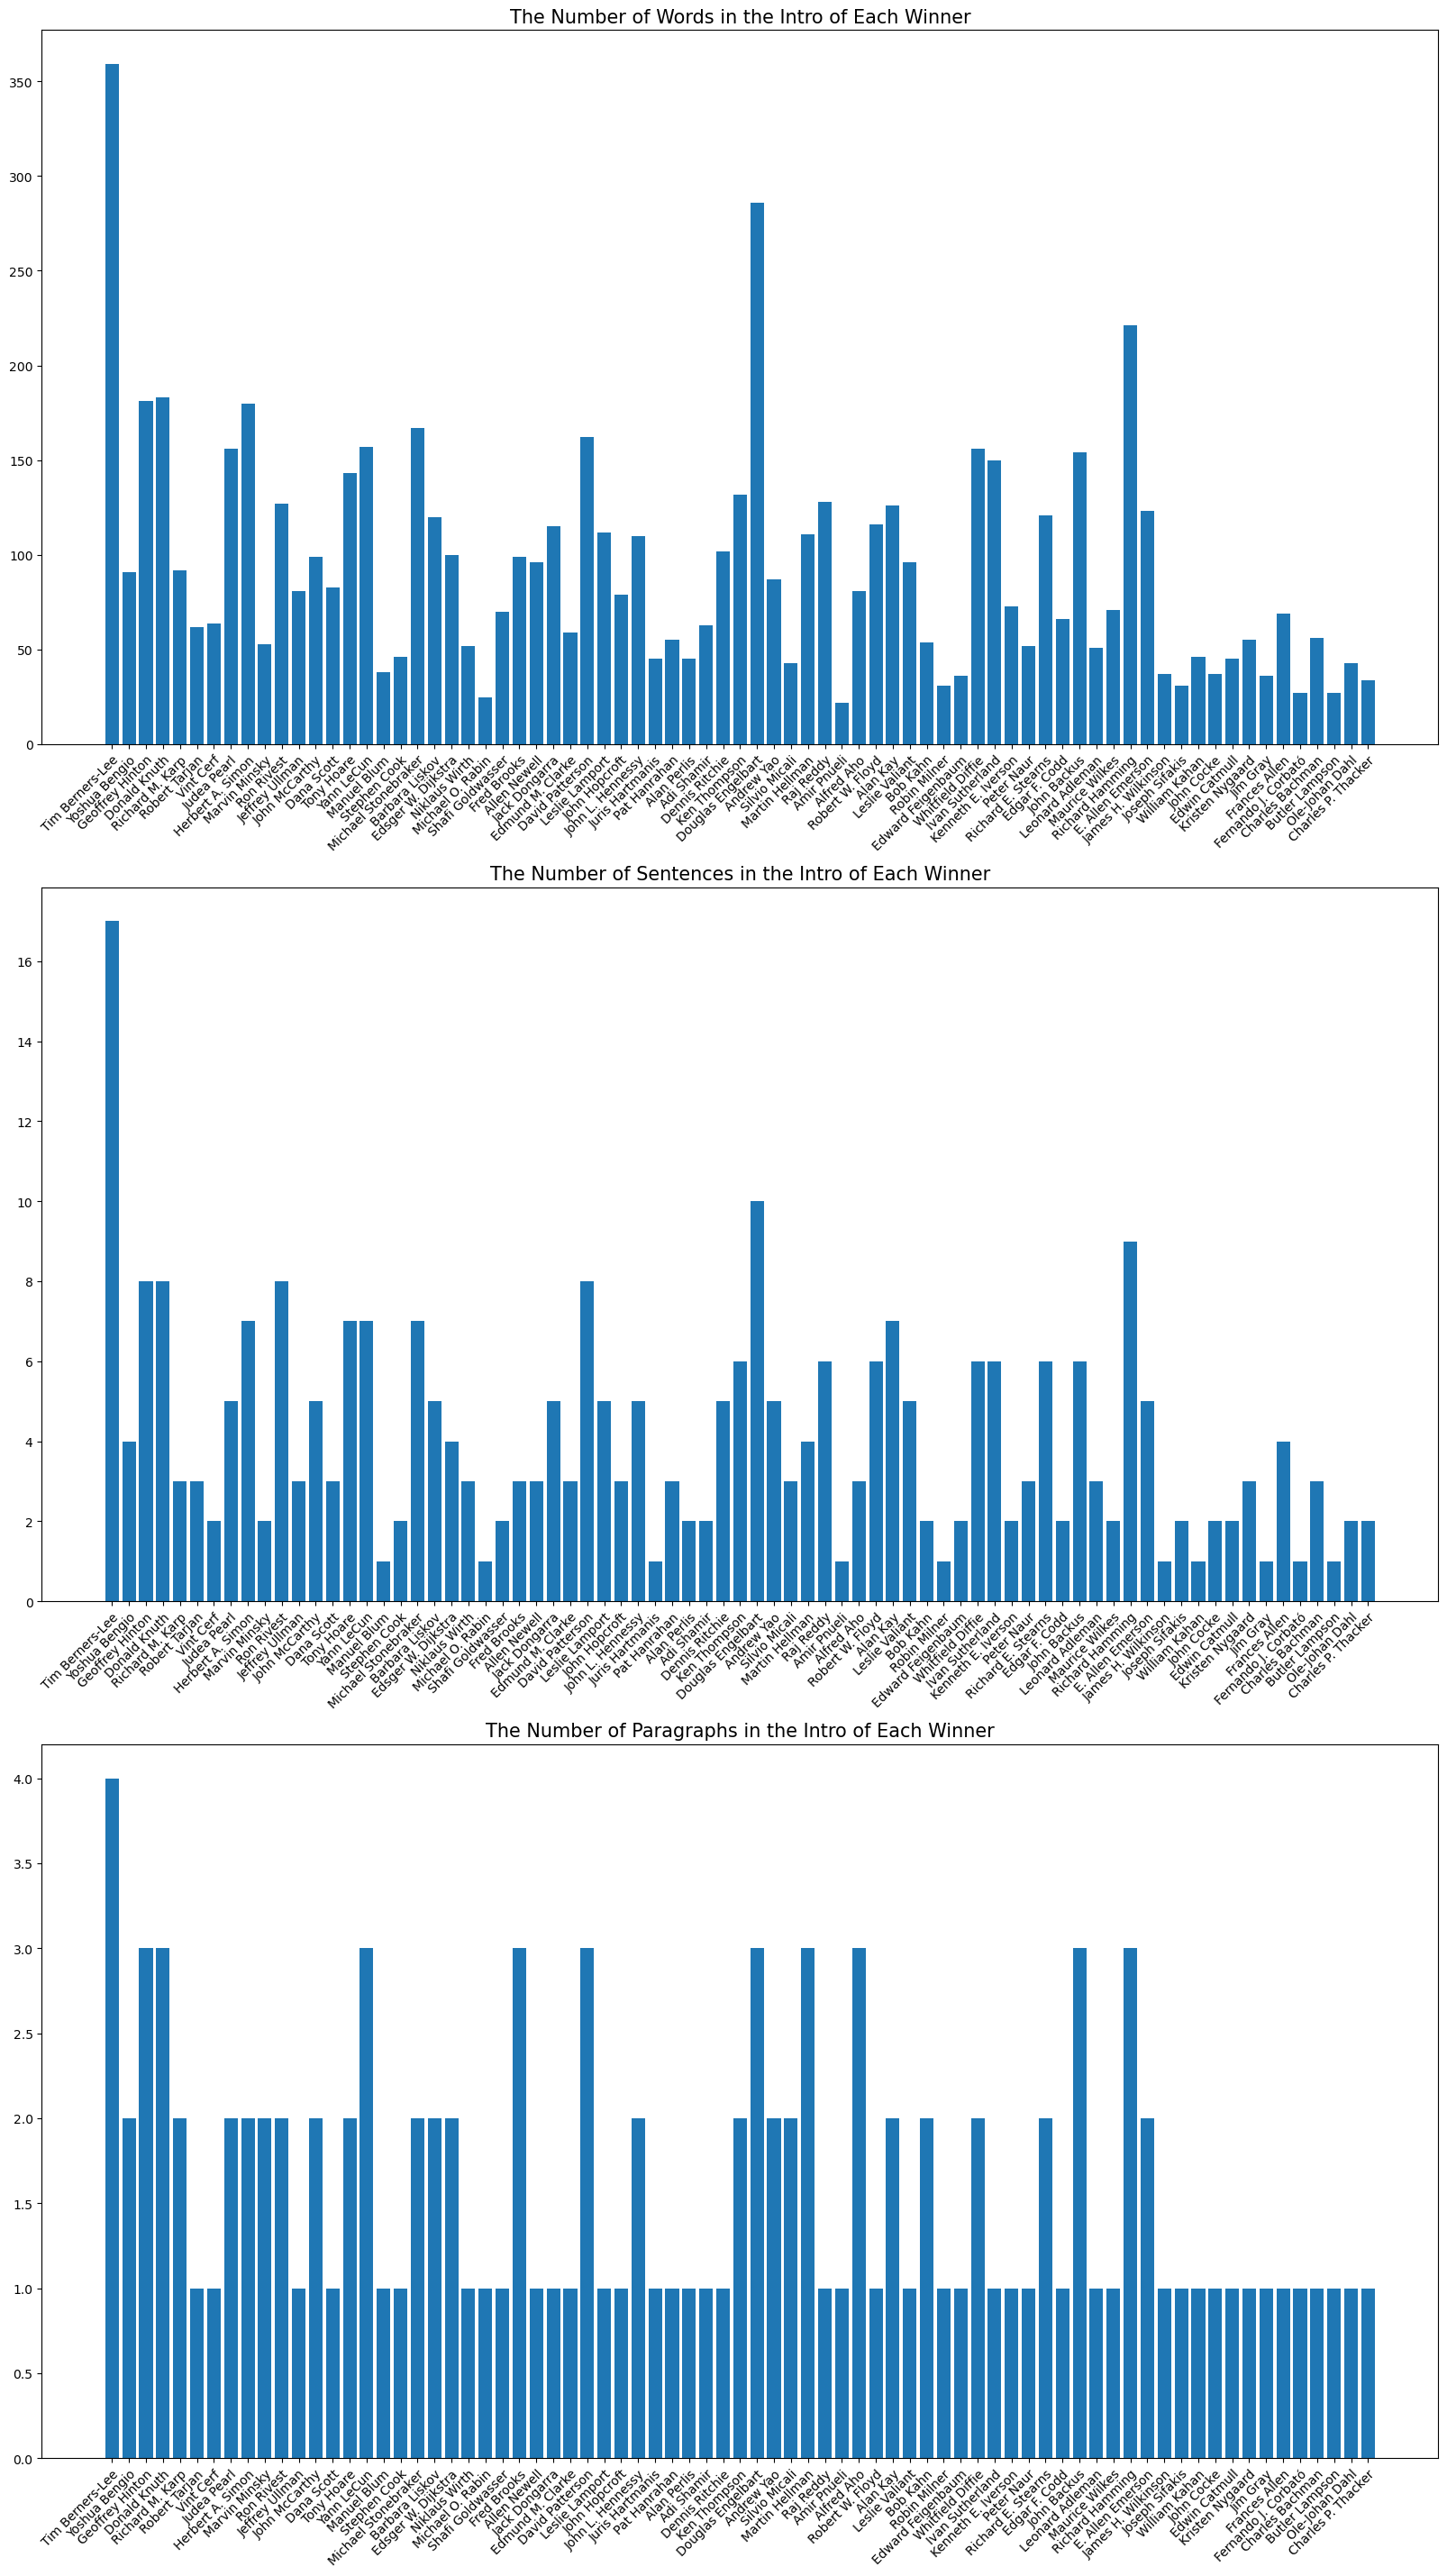

In [32]:
# Create a figure and axes (three rows and one column) and set the size of the figure to (20, 35)
fig, axs = plt.subplots(3,1, figsize = (20, 35))
# Add the title of the 1st plot
axs[0].set_title("The Number of Words in the Intro of Each Winner", fontsize = 15)
# Plot the 1st bar chart
axs[0].bar(award_winners_intro["winner_name"], award_winners_intro["count_words"])
# Set the name labels 45 degrees to have a better view
axs[0].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
axs[1].set_title("The Number of Sentences in the Intro of Each Winner", fontsize = 15)
axs[1].bar(award_winners_intro["winner_name"], award_winners_intro["count_sentences"])
axs[1].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
axs[2].set_title("The Number of Paragraphs in the Intro of Each Winner", fontsize = 15)
axs[2].bar(award_winners_intro["winner_name"], award_winners_intro["count_paragraphs"])
axs[2].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
# Show the plot
plt.show()

### Task 13

/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_21407/1313780424.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(sorted_word_count["winner_name"], rotation = 90)
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_21407/1313780424.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(sorted_sentence_count["winner_name"], rotation = 90)


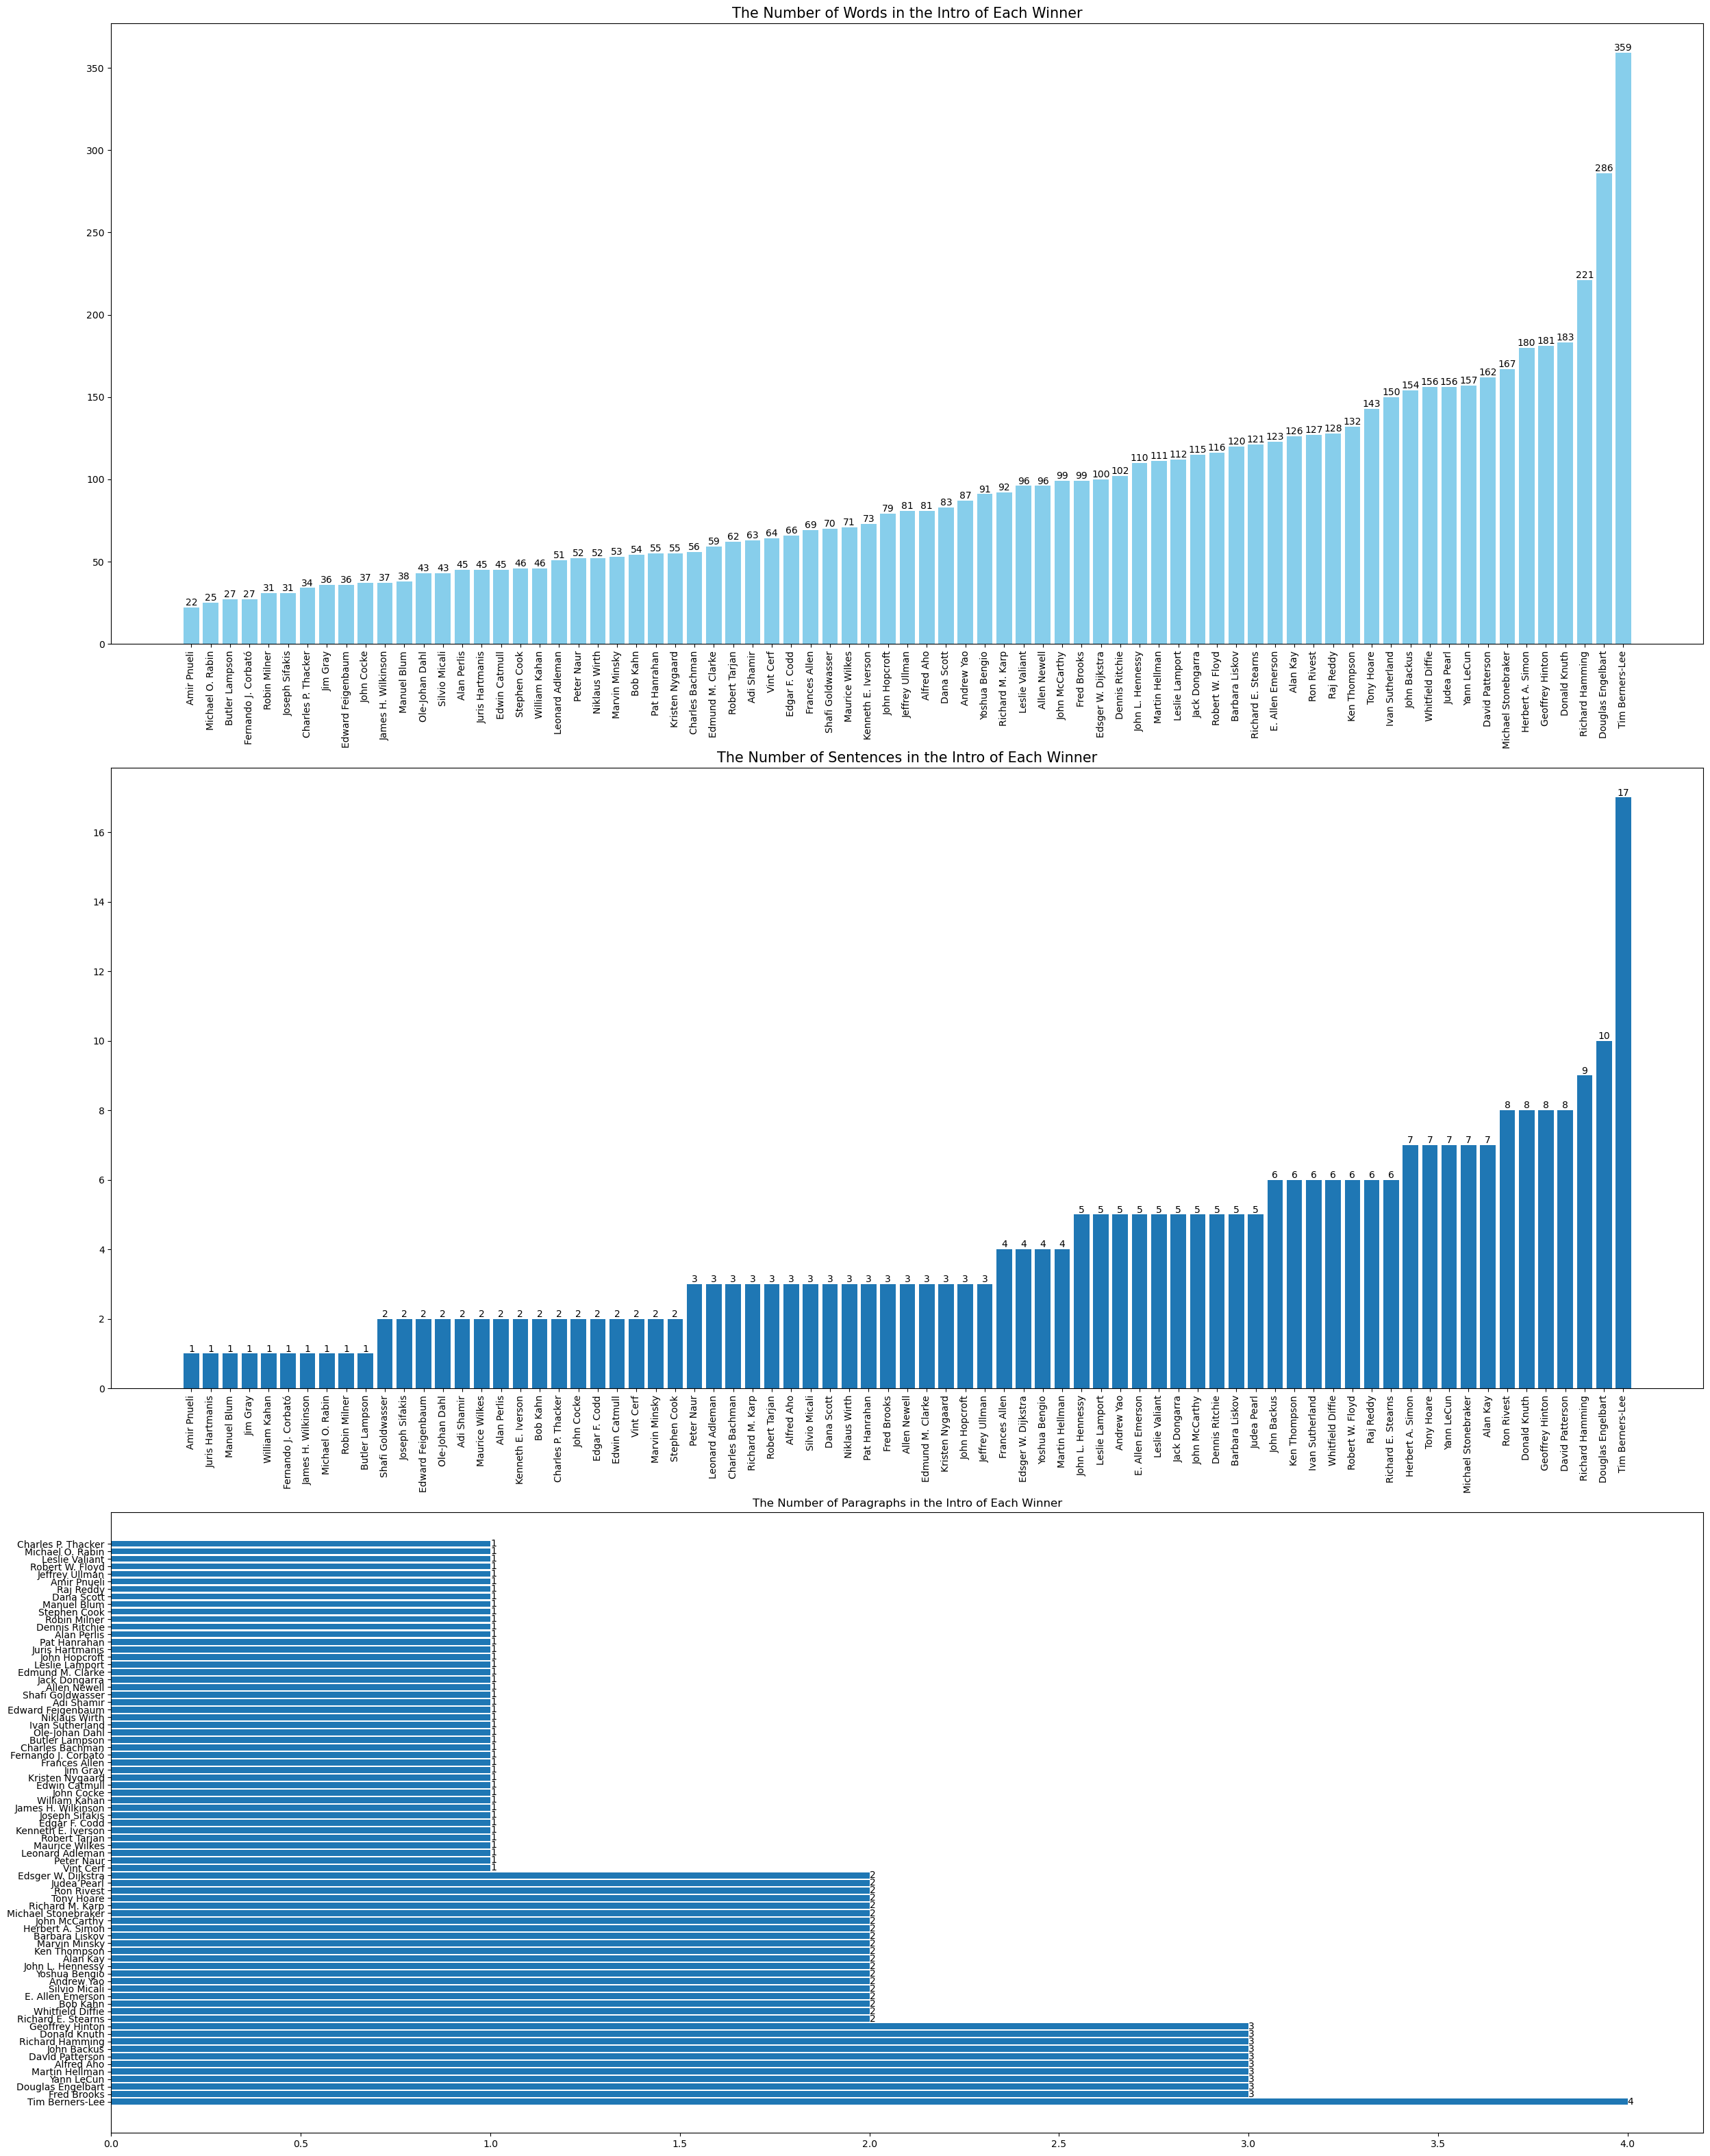

In [33]:
# Sort the counts before plotting
sorted_word_count = award_winners_intro.sort_values(by = "count_words", ascending = True)
sorted_sentence_count = award_winners_intro.sort_values(by = "count_sentences", ascending = True)
sorted_paragraph_count = award_winners_intro.sort_values(by = "count_paragraphs", ascending = False)

# Create a figure and axes (three rows and one column) and set the size of the figure to (30, 40)
fig, axs = plt.subplots(3,1, figsize = (30, 40))
# Add a title to the figure
axs[0].set_title("The Number of Words in the Intro of Each Winner", fontsize = 15)
# Plot the bar chart and change the color of the bar chart to skyblue
axs[0].bar(sorted_word_count["winner_name"], sorted_word_count["count_words"], color = "skyblue")
# Add numbers on top of the bars
axs[0].bar_label(axs[0].containers[0])
# Rotate the name labels 90 degrees
axs[0].set_xticklabels(sorted_word_count["winner_name"], rotation = 90)
axs[1].set_title("The Number of Sentences in the Intro of Each Winner", fontsize = 15)
axs[1].bar(sorted_sentence_count["winner_name"], sorted_sentence_count["count_sentences"])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_xticklabels(sorted_sentence_count["winner_name"], rotation = 90)
axs[2].set_title("The Number of Paragraphs in the Intro of Each Winner")
axs[2].barh(sorted_paragraph_count["winner_name"], sorted_paragraph_count["count_paragraphs"])
axs[2].bar_label(axs[2].containers[0])
# Show the plot
plt.show()

### 3.3.2 Heatmap

### Task 14

In [34]:
# Remove punctuations and stopwords in the intro
intros_remove_stopword_punctuation = []
for intro in award_winners["intro"]:
    # Remove punctuation
    tokens = word_tokenize(re.sub(r"[^\w\s]", "", intro))
    # Remove stopwords
    no_stopword_punctuation = [word for word in tokens if word.lower() not in en_stopwords]
    intros_remove_stopword_punctuation.append(no_stopword_punctuation)

# Get the bigrams frequency for each winner
intro_bigrams = [dict(FreqDist(ngrams(intro, 2))) for intro in intros_remove_stopword_punctuation]

# Create a list of dictionaries for the heatmap
heatmap_data = []
for intro_bigram in intro_bigrams:
    intro_bigram_list = {key: intro_bigram[key] for key in most_15_common_bigrams.keys() if key in intro_bigram.keys()}
    heatmap_data.append(intro_bigram_list)

In [35]:
# Create a dataframe for the heatmap
heatmap_df = pd.DataFrame(heatmap_data, index = award_winners["name"])
# Fill the 0 frequency with 0
heatmap_df = heatmap_df.fillna(0)
# Transpose the dataframe to have the bigrams as columns
heatmap_df_transpose = heatmap_df.transpose()

<AxesSubplot:title={'center':'The 15 Most Common Bigrams in the Intro of the Winners'}>

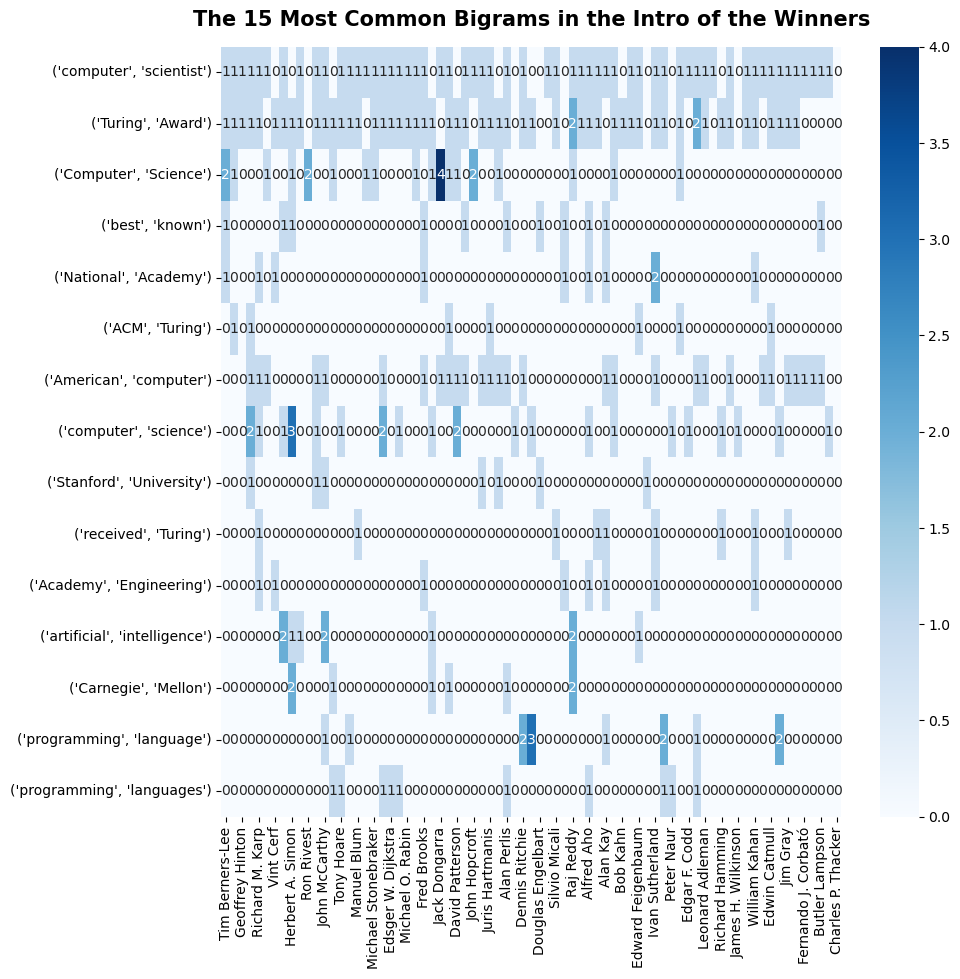

In [36]:
# Set the size of the figure
plt.figure(figsize = (10,10))
# Add a title to the plot
plt.title("The 15 Most Common Bigrams in the Intro of the Winners", fontsize = 15, pad = 15, fontweight = "bold")
# Plot the heatmap
sns.heatmap(heatmap_df_transpose, cmap = "Blues", annot = True)